In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#File path on Google Drive
data = pd.read_csv('/content/drive/MyDrive/salesdaily.csv', parse_dates=['datum'], index_col='datum')

In [ ]:
#preparing data, by creating weekly data with average sales per week
data['M01AB'] = pd.to_numeric(data['M01AB'], errors='coerce')
data_weekly = data['M01AB'].resample('W').mean().fillna(method='ffill')
print(data_weekly)

datum
2014-01-05    3.500000
2014-01-12    4.190000
2014-01-19    4.381429
2014-01-26    4.857143
2014-02-02    4.431429
                ...   
2019-09-15    5.072857
2019-09-22    6.691429
2019-09-29    4.858571
2019-10-06    5.528571
2019-10-13    3.835000
Freq: W-SUN, Name: M01AB, Length: 302, dtype: float64


<ipython-input-13-5a2aad9e0f5c>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_weekly = data['M01AB'].resample('W').mean().fillna(method='ffill')  # Resample to weekly frequency


In [ ]:
file_path = '/content/drive/My Drive/weekly_sales_data.csv'
data_weekly.to_csv(file_path)

print(f"Data saved to {file_path}")

Data saved to /content/drive/My Drive/weekly_sales_data.csv


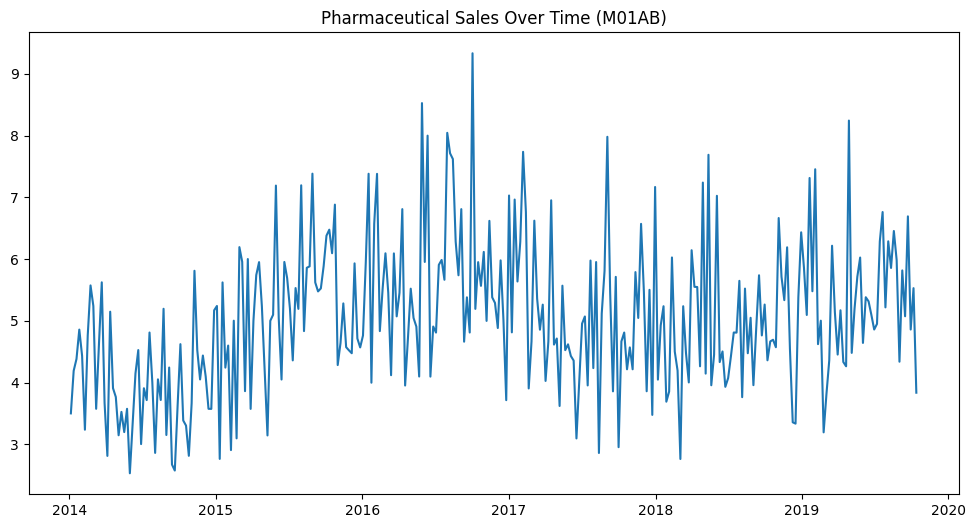

In [ ]:
# Visualizing the data
plt.figure(figsize=(12, 6))
plt.plot(data_weekly, label='Weekly Sales - M01AB')
plt.title('Pharmaceutical Sales Over Time (M01AB)')
plt.show()

In [ ]:
# Train and test data split
train_size = int(len(data_weekly) * 0.8)
train, test = data_weekly[:train_size], data_weekly[train_size:]


In [ ]:
# ARIMA Model
print("\nRunning ARIMA Model...")
arima_model = ARIMA(train, order=(5, 1, 0))  # Adjust (p, d, q) based on your data
arima_result = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_result.forecast(steps=len(test))
arima_mse = mean_squared_error(test, arima_forecast)
arima_mape = mean_absolute_percentage_error(test, arima_forecast)
print(f'ARIMA Model MSE: {arima_mse}, MAPE: {arima_mape}')


Running ARIMA Model...
ARIMA Model MSE: 1.1186726680960863, MAPE: 0.14878516608248732


In [ ]:
# XGBoost Model
print("\nRunning XGBoost Model...")
# Lag feature (create a shifted feature)
train_lag = train.shift(1).fillna(0)
test_lag = test.shift(1).fillna(0)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
xgb_model.fit(train_lag.values.reshape(-1, 1), train.values)

# Forecast using XGBoost
xgb_forecast = xgb_model.predict(test_lag.values.reshape(-1, 1))
xgb_mse = mean_squared_error(test, xgb_forecast)
xgb_mape = mean_absolute_percentage_error(test, xgb_forecast)
print(f'XGBoost Model MSE: {xgb_mse}, MAPE: {xgb_mape}')



Running XGBoost Model...
XGBoost Model MSE: 1.2607684040242142, MAPE: 0.16570663210920464


In [ ]:
# Step 9: LSTM Model
print("\nRunning LSTM Model...")
# Scale the data between 0 and 1 for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Create training data for LSTM
X_train, y_train = [], []
for i in range(1, len(train_scaled)):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], 1, 1))

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare test data for LSTM
X_test = []
for i in range(1, len(test_scaled)):
    X_test.append(test_scaled[i-1:i, 0])

X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, 1))

# Forecast using LSTM
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Inverse scaling to original scale
lstm_mse = mean_squared_error(test[1:], lstm_forecast)
lstm_mape = mean_absolute_percentage_error(test[1:], lstm_forecast)
print(f'LSTM Model MSE: {lstm_mse}, MAPE: {lstm_mape}')


Running LSTM Model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1516
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1326  
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1056  
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0844 
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0570 
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320 
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336 
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

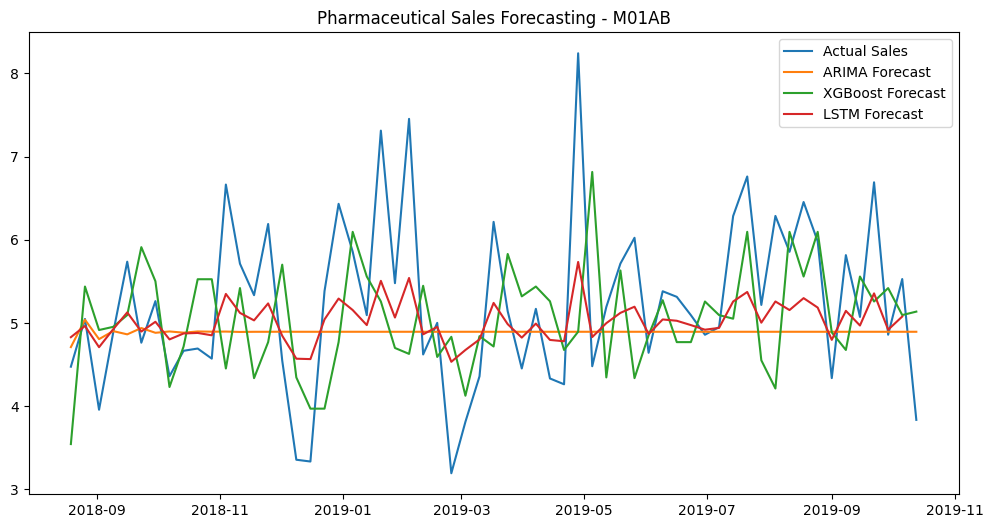

In [ ]:
# Step 10: Plot the results
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(test.index, test, label='Actual Sales')

# Ensure forecasts and test indices have the same length by removing slicing
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')

# Do the same for XGBoost and LSTM forecasts
plt.plot(test.index, xgb_forecast, label='XGBoost Forecast')

# Flatten LSTM forecast to match the shape of the test index
plt.plot(test.index[:-1], lstm_forecast.flatten(), label='LSTM Forecast')  # Adjusted index

plt.title('Pharmaceutical Sales Forecasting - M01AB')
plt.legend()
plt.show()